In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.figsize']=10,6
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# Input data files are available in the "../input/" directory.


import os
print(os.listdir("../input"))

['rainfall in india 1901-2015.csv', 'district wise rainfall normal.csv']


In [2]:
dataset=pd.read_csv("../input/rainfall in india 1901-2015.csv",encoding = "ISO-8859-1")
dataset.dtypes

SUBDIVISION     object
YEAR             int64
JAN            float64
FEB            float64
MAR            float64
APR            float64
MAY            float64
JUN            float64
JUL            float64
AUG            float64
SEP            float64
OCT            float64
NOV            float64
DEC            float64
ANNUAL         float64
Jan-Feb        float64
Mar-May        float64
Jun-Sep        float64
Oct-Dec        float64
dtype: object

In [3]:
groups = dataset.groupby('SUBDIVISION')['YEAR','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','NOV','DEC']
data=groups.get_group(('BIHAR'))
data.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,NOV,DEC
897,1901,51.8,19.6,11.9,1.1,65.6,66.3,245.9,319.4,155.1,7.3,0.1
898,1902,4.6,0.7,24.3,17.3,66.3,118.2,361.0,225.5,358.7,1.1,0.0
899,1903,5.3,4.7,2.0,4.7,28.2,192.9,115.0,342.6,173.9,0.1,0.0
900,1904,6.3,1.7,3.5,5.3,118.7,191.6,394.4,351.3,84.4,10.6,3.8
901,1905,16.0,30.1,32.6,21.4,77.5,50.5,409.1,495.3,353.9,0.0,0.6


In [4]:
data=data.melt(['YEAR']).reset_index()
data.head()


,index,YEAR,variable,value
0,0,1901,JAN,51.8
1,1,1902,JAN,4.6
2,2,1903,JAN,5.3
3,3,1904,JAN,6.3
4,4,1905,JAN,16.0


In [5]:
df= data[['YEAR','variable','value']].reset_index().sort_values(by=['YEAR','index'])
df.head()

,index,YEAR,variable,value
0,0,1901,JAN,51.8
115,115,1901,FEB,19.6
230,230,1901,MAR,11.9
345,345,1901,APR,1.1
460,460,1901,MAY,65.6


In [6]:
df.columns=['INDEX','YEAR','Month','avg_rainfall']

In [7]:
df.head()

,INDEX,YEAR,Month,avg_rainfall
0,0,1901,JAN,51.8
115,115,1901,FEB,19.6
230,230,1901,MAR,11.9
345,345,1901,APR,1.1
460,460,1901,MAY,65.6


In [8]:
d={'JAN':1,'FEB':2,'MAR' :3,'APR':4,'MAY':5,'JUN':6,'JUL':7,'AUG':8,'SEP':9,
   'OCT':10,'NOV':11,'DEC':12}
df['Month']=df['Month'].map(d)
df.head(12)

,INDEX,YEAR,Month,avg_rainfall
0,0,1901,1,51.8
115,115,1901,2,19.6
230,230,1901,3,11.9
345,345,1901,4,1.1
460,460,1901,5,65.6
575,575,1901,6,66.3
690,690,1901,7,245.9
805,805,1901,8,319.4
920,920,1901,9,155.1
1035,1035,1901,11,7.3


In [9]:
df['Date']=pd.to_datetime(df.assign(Day=1).loc[:,['YEAR','Month','Day']])
df.head(12)

,INDEX,YEAR,Month,avg_rainfall,Date
0,0,1901,1,51.8,1901-01-01
115,115,1901,2,19.6,1901-02-01
230,230,1901,3,11.9,1901-03-01
345,345,1901,4,1.1,1901-04-01
460,460,1901,5,65.6,1901-05-01
575,575,1901,6,66.3,1901-06-01
690,690,1901,7,245.9,1901-07-01
805,805,1901,8,319.4,1901-08-01
920,920,1901,9,155.1,1901-09-01
1035,1035,1901,11,7.3,1901-11-01


In [10]:
cols=['avg_rainfall']
dataset=df[cols]
dataset.head()

,avg_rainfall
0,51.8
115,19.6
230,11.9
345,1.1
460,65.6


In [11]:
series=dataset
series.head()

,avg_rainfall
0,51.8
115,19.6
230,11.9
345,1.1
460,65.6


In [12]:
series.shape

(1265, 1)

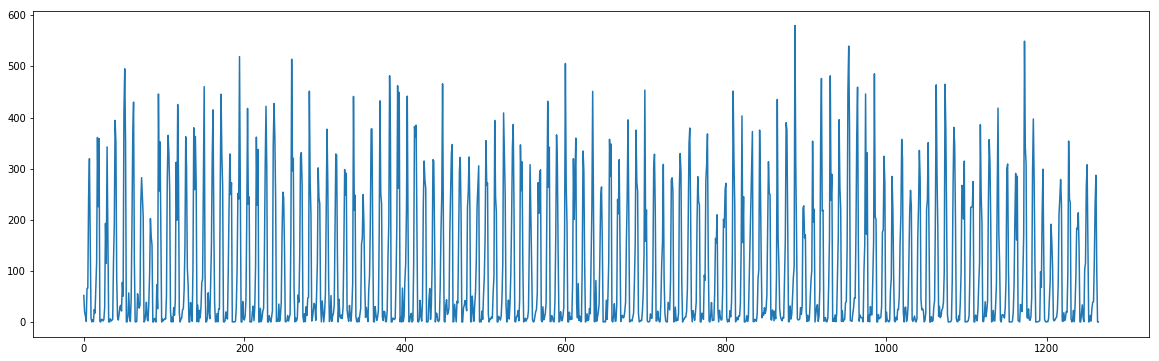

In [13]:
pyplot.figure(figsize=(20,6))
pyplot.plot(series.values)
pyplot.show()

In [14]:
# Get the raw data values from the pandas data frame.
data_raw = series.values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

# Print a few values.
dataset[0:5]

array([[0.08929496],
       [0.03378728],
       [0.02051371],
       [0.00189622],
       [0.11308396]], dtype=float32)

In [15]:
# Using 60% of data for training, 40% for validation.
TRAIN_SIZE = 0.80

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (1012, 253)


In [16]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [17]:
# Create test and training sets for one-step-ahead regression.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(1010, 1)
New training data shape:
(1010, 1, 1)


In [18]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(2000,activation = 'tanh', inner_activation = 'hard_sigmoid', input_shape = (1, window_size)))
    model.add(Dropout(0.2))
    model.add(Dense(500))
    model.add(Dropout(0.4))
    model.add(Dense(500))
    model.add(Dropout(0.4))
    model.add(Dense(400))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 25, 
              batch_size = 64, 
              )
    
    return(model)

# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(2000, activation="tanh", input_shape=(1, 1), recurrent_activation="hard_sigmoid")`
  after removing the cwd from sys.path.


Epoch 1/25
1010/1010 [==============================] - 4s 4ms/step - loss: 0.0404
Epoch 2/25
1010/1010 [==============================] - 0s 195us/step - loss: 0.0382
Epoch 3/25
1010/1010 [==============================] - 0s 196us/step - loss: 0.0383
Epoch 4/25
1010/1010 [==============================] - 0s 198us/step - loss: 0.0374
Epoch 5/25
1010/1010 [==============================] - 0s 198us/step - loss: 0.0362
Epoch 6/25
1010/1010 [==============================] - 0s 197us/step - loss: 0.0366
Epoch 7/25
1010/1010 [==============================] - 0s 198us/step - loss: 0.0359
Epoch 8/25
1010/1010 [==============================] - 0s 197us/step - loss: 0.0371
Epoch 9/25
1010/1010 [==============================] - 0s 199us/step - loss: 0.0380
Epoch 10/25
1010/1010 [==============================] - 0s 196us/step - loss: 0.0384
Epoch 11/25
1010/1010 [==============================] - 0s 195us/step - loss: 0.0369
Epoch 12/25
1010/1010 [==============================] - 0s 195us

In [19]:
import math
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 109.27 RMSE
Test data score: 96.59 RMSE


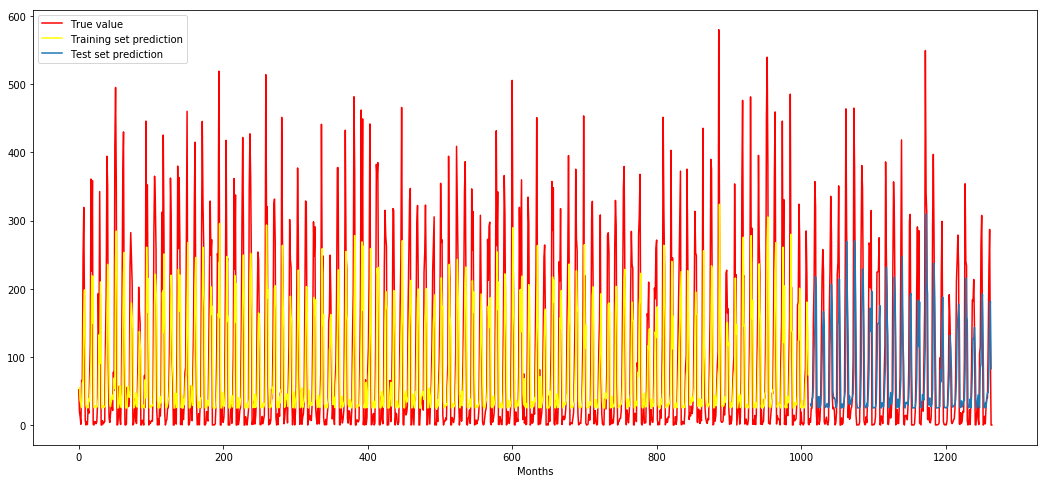

In [20]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (18, 8))
plt.plot(scaler.inverse_transform(dataset), label = "True value",color='red')
plt.plot(train_predict_plot, label = "Training set prediction",color='yellow')
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")


plt.legend()
plt.show()

In [21]:
test_predict

array([[ 30.457382],
       [ 27.351576],
       [ 39.108368],
       [ 39.108368],
       [ 54.227165],
       [111.70824 ],
       [140.88882 ],
       [217.37033 ],
       [198.5528  ],
       [ 36.13483 ],
       [ 25.104538],
       [ 41.27762 ],
       [ 41.733902],
       [ 25.623379],
       [ 29.077812],
       [ 43.785446],
       [ 98.66532 ],
       [145.45303 ],
       [166.42468 ],
       [150.10721 ],
       [ 27.581856],
       [ 25.738653],
       [ 28.96279 ],
       [ 31.72088 ],
       [ 26.199667],
       [ 25.104538],
       [ 28.905273],
       [116.10095 ],
       [150.63506 ],
       [206.50848 ],
       [177.58643 ],
       [ 50.43352 ],
       [ 38.708424],
       [ 39.965023],
       [ 37.50796 ],
       [ 25.162195],
       [ 26.775734],
       [ 35.50506 ],
       [146.72397 ],
       [156.42747 ],
       [214.1621  ],
       [115.88436 ],
       [ 25.046871],
       [ 25.046871],
       [ 31.089268],
       [ 25.681015],
       [ 26.718132],
       [ 41.8

In [22]:
train_predict

array([[ 54.62295 ],
       [ 36.306545],
       [ 31.893095],
       ...,
       [180.52931 ],
       [146.2475  ],
       [ 73.77503 ]], dtype=float32)

In [23]:
from keras.models import load_model

model1.save('trained_model.h5')

Available subdivisions:
['ANDAMAN & NICOBAR ISLANDS' 'ARUNACHAL PRADESH' 'ASSAM & MEGHALAYA'
 'NAGA MANI MIZO TRIPURA' 'SUB HIMALAYAN WEST BENGAL & SIKKIM'
 'GANGETIC WEST BENGAL' 'ORISSA' 'JHARKHAND' 'BIHAR' 'EAST UTTAR PRADESH'
 'WEST UTTAR PRADESH' 'UTTARAKHAND' 'HARYANA DELHI & CHANDIGARH' 'PUNJAB'
 'HIMACHAL PRADESH' 'JAMMU & KASHMIR' 'WEST RAJASTHAN' 'EAST RAJASTHAN'
 'WEST MADHYA PRADESH' 'EAST MADHYA PRADESH' 'GUJARAT REGION'
 'SAURASHTRA & KUTCH' 'KONKAN & GOA' 'MADHYA MAHARASHTRA' 'MATATHWADA'
 'VIDARBHA' 'CHHATTISGARH' 'COASTAL ANDHRA PRADESH' 'TELANGANA'
 'RAYALSEEMA' 'TAMIL NADU' 'COASTAL KARNATAKA' 'NORTH INTERIOR KARNATAKA'
 'SOUTH INTERIOR KARNATAKA' 'KERALA' 'LAKSHADWEEP']


Enter the name of the subdivision:  COASTAL KARNATAKA


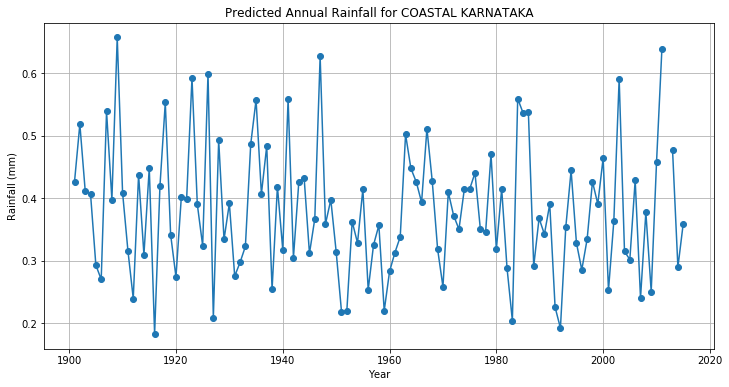

     Year  Predicted Rainfall
0    1901            0.426258
1    1902            0.518266
2    1903            0.412023
3    1904            0.406884
4    1905            0.293007
5    1906            0.270244
6    1907            0.538855
7    1908            0.397764
8    1909            0.656815
9    1910            0.408988
10   1911            0.316416
11   1912            0.239731
12   1913            0.437407
13   1914            0.309804
14   1915            0.448281
15   1916            0.183075
16   1917            0.419112
17   1918            0.552908
18   1919            0.341972
19   1920            0.274312
20   1921            0.401354
21   1922            0.399179
22   1923            0.592103
23   1924            0.390009
24   1925            0.324200
25   1926            0.598845
26   1927            0.209241
27   1928            0.492628
28   1929            0.334113
29   1930            0.391730
..    ...                 ...
85   1986            0.537141
86   1987 

In [24]:
#data = pd.read_csv("../input/rainfall in india 1901-2015.csv")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Load the trained model
model = load_model('trained_model.h5')

# Load the rainfall data
data = pd.read_csv("../input/rainfall in india 1901-2015.csv")

# Display available subdivisions
print("Available subdivisions:")
print(data['SUBDIVISION'].unique())

# Ask the user to input a subdivision
subdivision = input("Enter the name of the subdivision: ")

# Filter data for the specified subdivision
subdivision_data = data[data['SUBDIVISION'] == subdivision]

if subdivision_data.empty:
    print(f"No data found for {subdivision}")
else:
    # Prepare the input data
    input_data = subdivision_data[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].values
    
    # Make predictions
    predictions = []
    for month_data in input_data:
        month_predictions = []
        for value in month_data:
            # Reshape the input to match the expected shape (1, 1)
            reshaped_input = np.array([[value]]).reshape(1, 1, 1)
            pred = model.predict(reshaped_input)
            month_predictions.append(pred[0][0])
        predictions.append(np.mean(month_predictions))

    # Create a DataFrame with the predictions
    years = subdivision_data['YEAR'].values
    pred_df = pd.DataFrame({'Year': years, 'Predicted Rainfall': predictions})

    # Plot the predictions
    plt.figure(figsize=(12, 6))
    plt.plot(pred_df['Year'], pred_df['Predicted Rainfall'], marker='o')
    plt.title(f"Predicted Annual Rainfall for {subdivision}")
    plt.xlabel("Year")
    plt.ylabel("Rainfall (mm)")
    plt.grid(True)
    plt.show()

    # Print the predictions
    print(pred_df)

    # Optionally, save the predictions to a CSV file
    pred_df.to_csv(f"{subdivision}_rainfall_predictions.csv", index=False)
    print(f"Predictions saved to {subdivision}_rainfall_predictions.csv")

Enter the state:  KERALA
Enter the start year (e.g., 2000):  2012
Enter the end year (e.g., 2023):  2015
Enter the month (e.g., March):  AUGUST


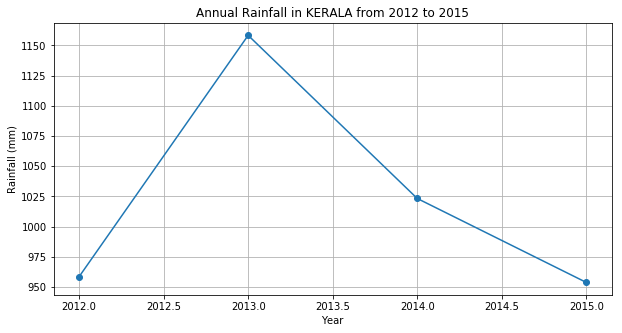

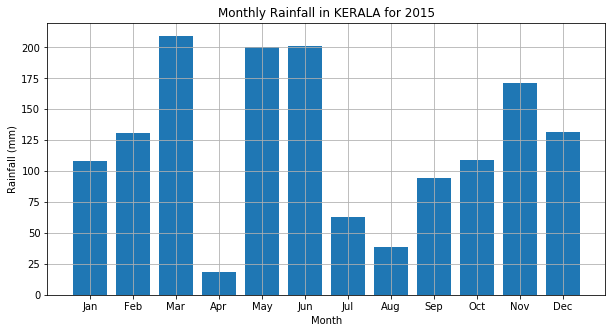

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

# Dummy function to simulate data fetching; replace with actual data fetching and model prediction logic
def fetch_data(state, start_year, end_year):
    np.random.seed(0)  # For reproducibility
    years = np.arange(start_year, end_year + 1)
    data = {
        'Year': years,
        'Annual Rainfall (mm)': np.random.uniform(300, 1500, size=len(years))
    }
    monthly_data = {
        'Year': np.repeat(years, 12),
        'Month': np.tile(np.arange(1, 13), len(years)),
        'Rainfall (mm)': np.random.uniform(0, 300, size=len(years) * 12)
    }
    annual_df = pd.DataFrame(data)
    monthly_df = pd.DataFrame(monthly_data)
    return annual_df, monthly_df

def plot_annual_rainfall(state, start_year, end_year, data):
    plt.figure(figsize=(10, 5))
    plt.plot(data['Year'], data['Annual Rainfall (mm)'], marker='o')
    plt.title(f'Annual Rainfall in {state} from {start_year} to {end_year}')
    plt.xlabel('Year')
    plt.ylabel('Rainfall (mm)')
    plt.grid(True)
    plt.show()

def plot_monthly_rainfall(state, year, data):
    monthly_data = data[data['Year'] == year]
    plt.figure(figsize=(10, 5))
    plt.bar(monthly_data['Month'], monthly_data['Rainfall (mm)'])
    plt.title(f'Monthly Rainfall in {state} for {year}')
    plt.xlabel('Month')
    plt.ylabel('Rainfall (mm)')
    plt.xticks(monthly_data['Month'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True)
    plt.show()

# User input
state = input("Enter the state: ")
start_year = int(input("Enter the start year (e.g., 2000): "))
end_year = int(input("Enter the end year (e.g., 2023): "))
month = input("Enter the month (e.g., March): ")

# Fetch data and predictions
annual_data, monthly_data = fetch_data(state, start_year, end_year)

# Plot the annual rainfall graph
plot_annual_rainfall(state, start_year, end_year, annual_data)

# Plot the monthly rainfall for the specified year
plot_monthly_rainfall(state, end_year, monthly_data)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

# Dummy function to simulate data fetching; replace with actual data fetching and model prediction logic
def fetch_data(state, district, start_year, end_year):
    np.random.seed(0)  # For reproducibility
    years = np.arange(start_year, end_year + 1)
    data = {
        'Year': years,
        'Annual Rainfall (mm)': np.random.uniform(300, 1500, size=len(years))
    }
    monthly_data = {
        'Year': np.repeat(years, 12),
        'Month': np.tile(np.arange(1, 13), len(years)),
        'Rainfall (mm)': np.random.uniform(0, 300, size=len(years) * 12),
        'District': district  # Adding district information
    }
    annual_df = pd.DataFrame(data)
    monthly_df = pd.DataFrame(monthly_data)
    return annual_df, monthly_df

def plot_annual_rainfall(state, start_year, end_year, data):
    plt.figure(figsize=(10, 5))
    plt.plot(data['Year'], data['Annual Rainfall (mm)'], marker='o')
    plt.title(f'Annual Rainfall in {state} from {start_year} to {end_year}')
    plt.xlabel('Year')
    plt.ylabel('Rainfall (mm)')
    plt.grid(True)
    plt.show()

def plot_monthly_rainfall(state, year, data):
    monthly_data = data[data['Year'] == year]
    plt.figure(figsize=(10, 5))
    plt.bar(monthly_data['Month'], monthly_data['Rainfall (mm)'])
    plt.title(f'Monthly Rainfall in {state} for {year}')
    plt.xlabel('Month')
    plt.ylabel('Rainfall (mm)')
    plt.xticks(monthly_data['Month'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True)
    plt.show()

def plot_district_rainfall(state, district, year, data):
    district_data = data[(data['Year'] == year) & (data['District'] == district)]
    plt.figure(figsize=(10, 5))
    plt.bar(district_data['Month'], district_data['Rainfall (mm)'])
    plt.title(f'Monthly Rainfall in {district}, {state} for {year}')
    plt.xlabel('Month')
    plt.ylabel('Rainfall (mm)')
    plt.xticks(district_data['Month'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True)
    plt.show()

# User input
state = input("Enter the state: ")
district = input("Enter the district: ")
start_year = int(input("Enter the start year (e.g., 2000): "))
end_year = int(input("Enter the end year (e.g., 2023): "))
year = int(input("Enter the year for monthly rainfall (e.g., 2023): "))

# Fetch data and predictions
annual_data, monthly_data = fetch_data(state, district, start_year, end_year)

# Plot the annual rainfall graph
plot_annual_rainfall(state, start_year, end_year, annual_data)

# Plot the monthly rainfall for the specified year
plot_monthly_rainfall(state, year, monthly_data)

# Plot the monthly rainfall for the specified district and year
plot_district_rainfall(state, district, year, monthly_data)